#  Concentration de CO2 dans l'atmosphère depuis 1958
## Importation des bibliothèques

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os
import urllib.request
import numpy as np
import sys
#Installation de la bibliothèque lmfit (si jamais l'utilisateur ne l'a pas, autrement à mettre en commentaire)
!{sys.executable} -m pip install lmfit 
import lmfit

Les donnéessur la concentration de CO$_2$ dans l'atmosphère sont disponibles du site Web de l'[institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à un mois de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1958 et se termine au 1er janvier 2020.

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"

Importation des données : Nous faisons une copie locale du fichier de données au cas où il y a modification du serveur du site de l'institut Scripps. Il est plus sûr de faire une copie du fichier en local au cas où le format/url change, pour travailler sur le même jeu de données et être reproductible.

In [3]:
data_file = "Concentration_CO2.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Voici l'explication des colonnes données [sur le site d'origine](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| Yr           | Année de la mesure                                                                                                     |
| Mn      | Mois de la mesure                                                                                              |
| Date            | Date de la mesure au format Excel                                                                       |
| Date       | Date de la mesure sous un autre format
| CO2        | Mesure de la concentration en CO2 en micro-mol CO2 per mol (ppm)                                                    |
| seasonally         | Même mesure mais avec soustraction de l'influence saisonniaire.                                                   |
| fit         | Ajustement de la courbe de la colonne 5 par un  modèle de fonction cubique avec 4 harmoniques et un gain linéaire.                                 |
| seasonally     | Ajustement de la courbe de la colonne 4 par un  modèle de fonction cubique avec 4 harmoniques et un gain linéaire. |
| CO2      | Copie de la colonne 5 avec les valeurs manquantes remplacées par les valeurs de la colonne 7. |
| seasonally      | Copie de la colonne 6 avec les valeurs manquantes remplacées par les valeurs de la colonne 8                          |
                                                      |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=54`.
Les **valeurs manquantes** sont dénotées **-99.99**.

## Mise en forme des données

In [4]:
raw_data = pd.read_csv(data_url, skiprows=54)
raw_data

Yr   Mn      Date        Date        CO2  seasonally          fit  \
0                                                  adjusted                
1                  Excel                  [ppm]      [ppm]         [ppm]   
2    1958   01     21200   1958.0411     -99.99      -99.99       -99.99   
3    1958   02     21231   1958.1260     -99.99      -99.99       -99.99   
4    1958   03     21259   1958.2027     315.70      314.44       316.19   
5    1958   04     21290   1958.2877     317.45      315.16       317.30   
6    1958   05     21320   1958.3699     317.51      314.71       317.86   
7    1958   06     21351   1958.4548     -99.99      -99.99       317.24   
8    1958   07     21381   1958.5370     315.86      315.19       315.86   
9    1958   08     21412   1958.6219     314.93      316.19       314.00   
10   1958   09     21443   1958.7068     313.21      316.08       312.46   
11   1958   10     21473   1958.7890     -99.99      -99.99       312.44   
12   1958   11     21504   1958.8740     313.33      315.20       313.62   
13   1958   12     21534   1958.9562     314.67      315.43       314.77   
14   1959   01     21565   1959.0411     315.58      315.54       315.62   
15   1959   02     21596   1959.1260     316.49      315.86       316.27   
16   1959   03     21624   1959.2027     316.65      315.38       316.98   
17   1959   04     21655   1959.2877     317.72      315.42       318.09   
18   1959   05     21685   1959.3699     318.29      315.49       318.65   
19   1959   06     21716   1959.4548     318.15      316.03       318.04   
20   1959   07     21746   1959.5370     316.54      315.86       316.67   
21   1959   08     21777   1959.6219     314.80      316.06       314.83   
22   1959   09     21808   1959.7068     313.84      316.72       313.32   
23   1959   10     21838   1959.7890     313.33      316.32       313.33   
24   1959   11     21869   1959.8740     314.81      316.68       314.54   
25   1959   12     21899   1959.9562     315.58      316.35       315.72   
26   1960   01     21930   1960.0410     316.43      316.39       316.61   
27   1960   02     21961   1960.1257     316.98      316.35       317.27   
28   1960   03     21990   1960.2049     317.58      316.28       318.03   
29   1960   04     22021   1960.2896     319.03      316.70       319.14   
..    ...  ...       ...         ...        ...         ...          ...   
728  2018   07     43296   2018.5370     408.90      408.08       409.43   
729  2018   08     43327   2018.6219     407.10      408.63       407.33   
730  2018   09     43358   2018.7068     405.59      409.09       405.66   
731  2018   10     43388   2018.7890     405.99      409.62       405.83   
732  2018   11     43419   2018.8740     408.12      410.39       407.47   
733  2018   12     43449   2018.9562     409.23      410.16       409.07   
734  2019   01     43480   2019.0411     410.92      410.87       410.29   
735  2019   02     43511   2019.1260     411.66      410.90       411.24   
736  2019   03     43539   2019.2027     412.00      410.45       412.25   
737  2019   04     43570   2019.2877     413.52      410.72       413.73   
738  2019   05     43600   2019.3699     414.83      411.42       414.54   
739  2019   06     43631   2019.4548     413.96      411.38       413.91   
740  2019   07     43661   2019.5370     411.85      411.03       412.36   
741  2019   08     43692   2019.6219     410.08      411.62       410.23   
742  2019   09     43723   2019.7068     408.55      412.06       408.52   
743  2019   10     43753   2019.7890     408.43      412.07       408.67   
744  2019   11     43784   2019.8740     410.28      412.56       410.29   
745  2019   12     43814   2019.9562     411.85      412.78       411.88   
746  2020   01     43845   2020.0410     413.37      413.33       413.11   
747  2020   02     43876   2020.1257     -99.99      -99.99       -99.99   
748  2020   03     43905   2020.2049     -99.99      -9

On peut remarquer que les deux premières lignes sont des commentaires pour se repérer dans les colonnes, elles nous sont inutiles pour le traitement. De même que les valeurs manquantes dénotées -99.99, il nous faut les supprimer.
Commençons par récupérer les colonnes qui nous intéressent, d'en supprimer les 2 premières lignes et de les convertir en nombre :

In [5]:
Dates=raw_data['      Date'][2:].values
data=raw_data['      CO2'][2:].values
for i in range(len(data)):
    data[i]=float(data[i])
    Dates[i]=float(Dates[i])

Cherchons maintenant à en supprimer les valeurs manquantes :

In [6]:
def Reduce(Dates,data):
    reduced_dates=list()
    reduced_data=list()
    for i in range(len(Dates)):
        if data[i]!=-99.99:
            reduced_data.append(data[i])
            reduced_dates.append(Dates[i])
    return reduced_data, reduced_dates
reduced_data, reduced_dates=Reduce(Dates,data)

Regardons maintenant l'allure de la courbe :

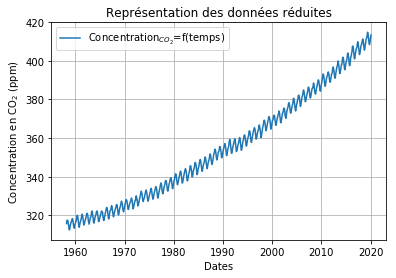

In [7]:
plt.plot(reduced_dates,reduced_data,label='Concentration$_{CO_{2}}$=f(temps)')
plt.legend()
plt.grid()
plt.xlabel('Dates')
plt.ylabel('Concentration en CO$_{2}$ (ppm)')
plt.title('Représentation des données réduites');

On observe que nous avons une oscillation périodique avec une tendance à la croître en fonction du temps. 

## Caractérisation des oscillations et de la tendance

1. Recherche d'un modèle général de la courbe

Dans le header du fichier de données, on nous dis que les données peuvent être ajustées par une fonction cubique et une somme d'harmonique. La fonction cubique représente la tendance de la courbe à augmenter au cours des ans tandis que la somme des harmoniques représente les oscillations de la courbe.

Nous définissons donc une fonction dont nous ajusterons ses paramètres à l'aide de la bibliothèque _lmfit_ par la méthode de [Levenberg-Marquardt](https://fr.wikipedia.org/wiki/Algorithme_de_Levenberg-Marquardt). La fonction proposée est la suivante :

$Model=a+b*(x-x_{0})^{c}+d*\frac{cos(2\pi*f*x)}{1!}+e*\frac{cos(2\pi*3f*x)}{3!}+g*\frac{cos(2\pi*5f*x)}{5!}+h*\frac{cos(2\pi*7f*x)}{7!}$

Nous choisissons ici d'exprimer la fonction cubique comme $a+b*(x-x_{0})^{c}$, avec _a_ l'ordonnée à l'origine, _b_ une constante de multiplication, _$x_{0}$_ une constante pour décaler la courbe dans le temps et _c_ une constante proche de 3 (pour avoir une fonction cubique).

Concernant le reste du modèle, cela représente le développement en série d'une fonction triangle jusqu'à la 4$^{e}$ harmonique. Comme ce développement comprend uniquement les harmoniques impaires, les harmoniques pertinentes sont 1,3,5 et 7. Le choix de la fonction triangle se justifie par l'allure de la courbe "à l'oeil", ce qui peut-être discutable bien évidemment. 

Par rapport aux noms des variables, celle qui nous intéresse le plus est la fréquence _f_, les autres termes _d,e,g_ et _h_ sont des constantes de multiplication pour l'ajustement de la courbe.

Les variables sont ensuite initialisées dans un vecteur w contenant des valeurs proches de celles attendues ou contenant des 1 pour celles dont on ne connaît absolument pas la valeur. On fait de même varier les variables entre des valeurs possibles.

In [8]:
#Définition du modèle
def FonctionModel(t,t0,A,B,C,D,E,F,G,a):
        return F+E*(t-t0)**G+A*np.cos(2*np.pi*a*t)+B*np.cos(2*np.pi*3*a*t)/9+C*np.cos(2*np.pi*5*a*t)/25+D*np.cos(2*np.pi*7*a*t)/49
    
gmodel = lmfit.Model(FonctionModel)

#Définition des paramètres d'ajustement
params=[]
params = lmfit.Parameters()
w=[1951,1,1,1,1,1,300,3,1]
params.add('t0', value=w[0], vary=True, min=0, max=1960)
params.add('A', value=w[1], vary=True, min=1, max=10000)
params.add('B', value=w[2], vary=True, min=1, max=10000)
params.add('C', value=w[3], vary=True, min=0, max=40000)
params.add('D', value=w[4], vary=True, min=0, max=40000)
params.add('E', value=w[5], vary=True, min=0, max=40000)
params.add('F', value=w[6], vary=True, min=0, max=40000)
params.add('G', value=w[7], vary=True, min=2.99, max=3.01)
params.add('a', value=w[8], vary=True, min=0.5, max=10)

#Ajustement
result=gmodel.fit(reduced_data,params,t=reduced_dates, scale_covar=True, fit_kws={'ftol': 1e-10, 'xtol': 1e-10,  'gtol': 1e-10})
print(result.fit_report())

[[Model]]
    Model(FonctionModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 349
    # data points      = 743
    # variables        = 9
    chi-square         = 645.056908
    reduced chi-square = 0.87882413
    Akaike info crit   = -87.0286239
    Bayesian info crit = -45.5323595
[[Variables]]
    t0:  1870.91642 +/- 25.0616894 (1.34%) (init = 1951)
    A:   2.84439867 +/- 0.04861780 (1.71%) (init = 1)
    B:   1.00000043 +/- 0.31892352 (31.89%) (init = 1)
    C:   0.64346148 +/- 1.25795087 (195.50%) (init = 1)
    D:   3.6390e-06 +/- 2.46794175 (67818852.73%) (init = 1)
    E:   3.8765e-05 +/- 9.9882e-05 (257.66%) (init = 1)
    F:   289.430736 +/- 4.19785528 (1.45%) (init = 300)
    G:   2.99059870 +/- 0.42153584 (14.10%) (init = 3)
    a:   0.99984556 +/- 1.3619e-06 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(E, G)  = -1.000
    C(t0, E) =  0.999
    C(t0, G) = -0.999
    C(t0, F) =  0.996
    C(E, F)  =  0.991

On remarque dans un premier temps que le $\chi^{2}$ est élevé, mais néanmoins regardons l'allure de la courbe ajustée.

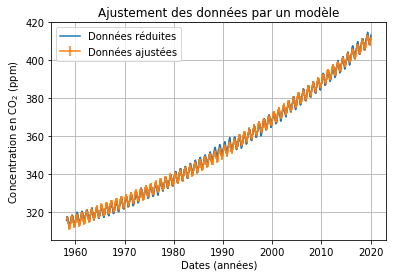

In [9]:
plt.plot(reduced_dates,reduced_data,label='Données réduites')
plt.errorbar(reduced_dates,result.best_fit,result.errorbars, label='Données ajustées')
plt.xlabel("Dates (années)")
plt.ylabel("Concentration en CO$_{2}$ (ppm)")
plt.legend()
plt.grid()
plt.title('Ajustement des données par un modèle');

On peut alors constater que l'ajustement n'est pas si mauvais, la tendance semble bien être représentée, de même que les oscillations. Le modèle semble être suffisant pour pouvoir extrapoler la courbe dans le futur.

2. Caractérisation de la tendance

Nous avons dis précédemment que la tendance de la courbe était représentée ici par une fonction cubique à quelques constantes prêt. Par les résultats de l'ajustement nous trouvons comme expression de la tendance :

$Tendance = 289.43+3.88.10^{-5}*(x-1870.92)^{2.99}$

Nous pouvons superposer cette fonction à la courbe pour vérifier si l'expression correspond bien (résultat ci-dessous), et cela semble être le cas.

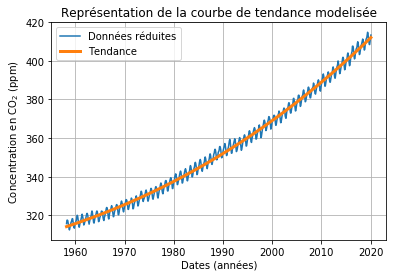

In [10]:
tendance=FonctionModel(reduced_dates,result.best_values['t0'],0,0,0,0,result.best_values['E'],result.best_values['F'],result.best_values['G'],np.zeros(len(reduced_dates)))
plt.plot(reduced_dates,reduced_data,label='Données réduites')
plt.plot(reduced_dates,tendance, label='Tendance', linewidth=3)
plt.xlabel("Dates (années)")
plt.ylabel("Concentration en CO$_{2}$ (ppm)")
plt.legend()
plt.grid()
plt.title('Représentation de la courbe de tendance modelisée');

3. Carctérisation des oscillations

Concernant les oscillations, les ajustements de la courbe nous permettent d'exprimer le modèle comme :

$Oscillation = 2.84*\frac{cos(2\pi*1*x)}{1!}+1.00*\frac{cos(2\pi*3*1*x)}{3!}+0.64*\frac{cos(2\pi*5*1*x)}{5!}+3.64.10^{-6}*\frac{cos(2\pi*7*1*x)}{7!}$

On peut alors faire plusieurs remarques :
- La fréquence est proche de 1/an.
- La première harmonique est la plus prépondérante.
- La dernière harmonique n'est pas indispensable pour cette modélisation puisque la constante est quasiment nulle.

Traçons ces oscillations pour vérifier leur allure et leur pretinence (résultat ci-dessous). On remarque sur le graphique que les oscillations sont globalement de type triangle, ce qui est attendu, de même on remarque que la période est d'environ 1 an, ce qui correspond donc bien à notre fréquence ajustée ($fréquence=\frac{1}{periode}$).

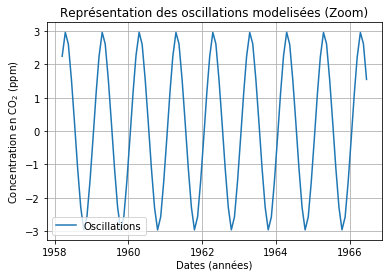

In [11]:
oscillation=FonctionModel(reduced_dates,result.best_values['t0'],result.best_values['A'],result.best_values['B'],result.best_values['C'],result.best_values['D'],np.zeros(len(reduced_dates)),0,0,np.ones(len(reduced_dates))*result.best_values['a'])
plt.plot(reduced_dates[:100],oscillation[:100], label='Oscillations')
plt.xlabel("Dates (années)")
plt.ylabel("Concentration en CO$_{2}$ (ppm)")
plt.legend()
plt.grid()
plt.title('Représentation des oscillations modelisées (Zoom)');

4. Estimation en 2025

Maintenant que nous avons modélisé une fonction permettant de décrire nos données, nous pouvons aisément extrapoler la courbe aux dates futures. Par exemple, déduisons ici la concentration en CO$_{2}$ pour le 1$^{er}$ janvier 2025 (calcul via le modèle ci-dessous). Nous trouvons une concentration de 425.40 ppm. Bien évidemment, cette valeur est à relativiser puisque nous n'avons pas pris en compte les incertitudes liées à l'ajustement des variables du modèle, bien qu'elles semblent correctes. La valeur calculée est de toute façon du même ordre de grandeur que les données et supérieure à la dernière mesure de 2020, donc on peut quand même supposer notre intertitude sur le résultat faible.

In [12]:
Estimation2025=FonctionModel(2025,result.best_values['t0'],result.best_values['A'],result.best_values['B'],result.best_values['C'],result.best_values['D'],result.best_values['E'],result.best_values['F'],result.best_values['G'],result.best_values['a'])
Estimation2025


423.6680255639254